# 1. Data Selection and Cleaning

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
df.shape

(142193, 24)

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [5]:
city = "Sydney"
df_Sydney = df[df["Location"] == city].copy()

In [6]:
df_Sydney.shape

(3337, 24)

In [7]:
df_Sydney.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [9]:
selected_features = [
    "Rainfall",       # Target
    "MinTemp",
    "MaxTemp",
    "Humidity3pm",
    "Pressure3pm",
    "WindSpeed3pm",
    "Cloud3pm",
    "RainToday"       # Binary indicator
]

In [10]:
df_selected = df_Sydney[selected_features]

In [11]:
missing_values = df_selected.isnull().sum()

In [14]:
print("Missing values per feature:")
print(missing_values)

Missing values per feature:
Rainfall          6
MinTemp           3
MaxTemp           2
Humidity3pm      13
Pressure3pm      19
WindSpeed3pm     25
Cloud3pm        561
RainToday         6
dtype: int64


## Missing Value Handling Strategy

We applied different imputation methods depending on the data type and distribution of each feature:

- **MinTemp & MaxTemp**: Used **mean imputation** because these are continuous variables with likely normal distributions. Mean works well when the data is symmetric and not heavily skewed.

- **Humidity3pm & WindSpeed3pm**: Used **median imputation** because these features can be skewed or have outliers (e.g., sudden humidity drops or wind spikes). Median is more robust in such cases.

- **Pressure3pm**: Used **mean imputation** assuming atmospheric pressure has a fairly stable, normal distribution.

- **Cloud3pm**: Used **mode imputation** because it is a categorical/ordinal feature (values from 0 to 8). The most frequent cloud cover is a good estimate.

- **RainToday**: Used **mode imputation** since it's a binary categorical feature ('Yes' or 'No') and using the most frequent value is typically reliable.

- **Rainfall**: Used **median imputation** to minimize the effect of outliers (heavy rain days).

These strategies ensure our dataset remains as complete and unbiased as possible without introducing distortions from inappropriate replacements.


In [19]:
# Handle missing values
df_selected["MinTemp"].fillna(df_selected["MinTemp"].mean(), inplace=True)
df_selected["MaxTemp"].fillna(df_selected["MaxTemp"].mean(), inplace=True)
df_selected["Humidity3pm"].fillna(df_selected["Humidity3pm"].median(), inplace=True)
df_selected["Pressure3pm"].fillna(df_selected["Pressure3pm"].mean(), inplace=True)
df_selected["WindSpeed3pm"].fillna(df_selected["WindSpeed3pm"].median(), inplace=True)
df_selected["Cloud3pm"].fillna(df_selected["Cloud3pm"].mode()[0], inplace=True)
df_selected["RainToday"].fillna(df_selected["RainToday"].mode()[0], inplace=True)
df_selected["Rainfall"].fillna(df_selected["Rainfall"].median(), inplace=True)

In [16]:
missing_values_after_fill = df_selected.isnull().sum()


In [17]:
print(missing_values_after_fill)

Rainfall        0
MinTemp         0
MaxTemp         0
Humidity3pm     0
Pressure3pm     0
WindSpeed3pm    0
Cloud3pm        0
RainToday       0
dtype: int64


In [20]:
# Compute z-scores
rainfall_z = (df_selected["Rainfall"] - df_selected["Rainfall"].mean()) / df_selected["Rainfall"].std()
maxtemp_z = (df_selected["MaxTemp"] - df_selected["MaxTemp"].mean()) / df_selected["MaxTemp"].std()

# Identify outliers (|z| > 3)
rainfall_outliers = df_selected[np.abs(rainfall_z) > 3]
maxtemp_outliers = df_selected[np.abs(maxtemp_z) > 3]

# Count outliers
print(f"Rainfall outliers: {rainfall_outliers.shape[0]}")
print(f"MaxTemp outliers: {maxtemp_outliers.shape[0]}")


Rainfall outliers: 71
MaxTemp outliers: 28


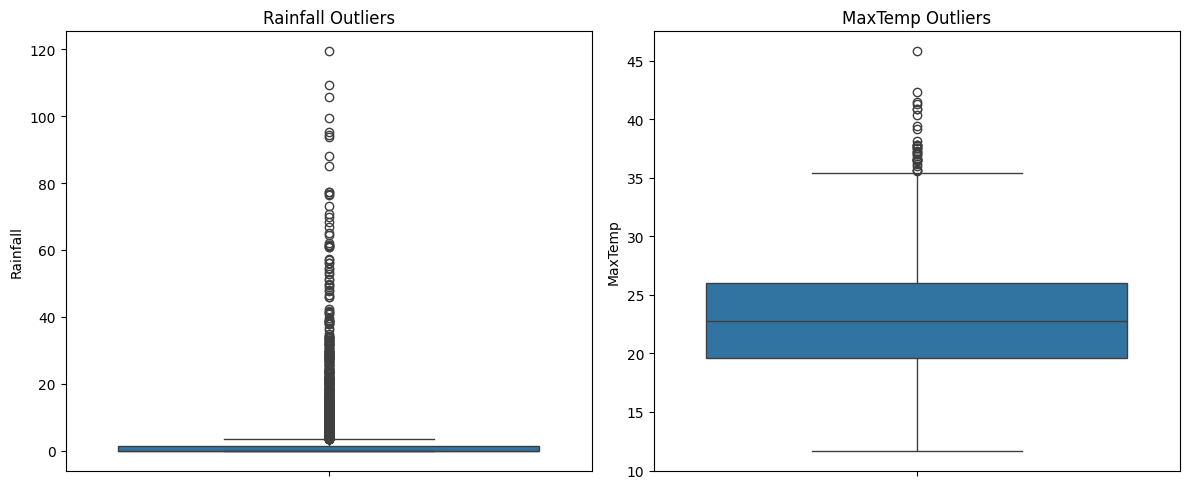

In [23]:
# Visualize outliers using boxplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_selected["Rainfall"])
plt.title("Rainfall Outliers")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_selected["MaxTemp"])
plt.title("MaxTemp Outliers")

plt.tight_layout()
plt.show()


In [24]:
# Define threshold
z_threshold = 3

# Recalculate z-scores
rainfall_z = (df_selected["Rainfall"] - df_selected["Rainfall"].mean()) / df_selected["Rainfall"].std()
maxtemp_z = (df_selected["MaxTemp"] - df_selected["MaxTemp"].mean()) / df_selected["MaxTemp"].std()

# Create mask for valid (non-outlier) entries
valid_rows = (np.abs(rainfall_z) <= z_threshold) & (np.abs(maxtemp_z) <= z_threshold)

# Filtered dataset without outliers
df_clean = df_selected[valid_rows].copy()


In [25]:
# Select columns to summarize
features = ["Rainfall", "MaxTemp"]

# Compute statistics before removal
summary_before = df_selected[features].agg(["mean", "median", "std"]).T
summary_before.columns = ["Mean (Before)", "Median (Before)", "Std Dev (Before)"]

# Compute statistics after removal
summary_after = df_clean[features].agg(["mean", "median", "std"]).T
summary_after.columns = ["Mean (After)", "Median (After)", "Std Dev (After)"]

# Combine for comparison
summary_comparison = pd.concat([summary_before, summary_after], axis=1)
summary_comparison


,Mean (Before),Median (Before),Std Dev (Before),Mean (After),Median (After),Std Dev (After)
Rainfall,3.324243,0.0,9.887277,2.199382,0.00,5.387403
MaxTemp,23.002339,22.8,4.493290,22.935517,22.85,4.264110


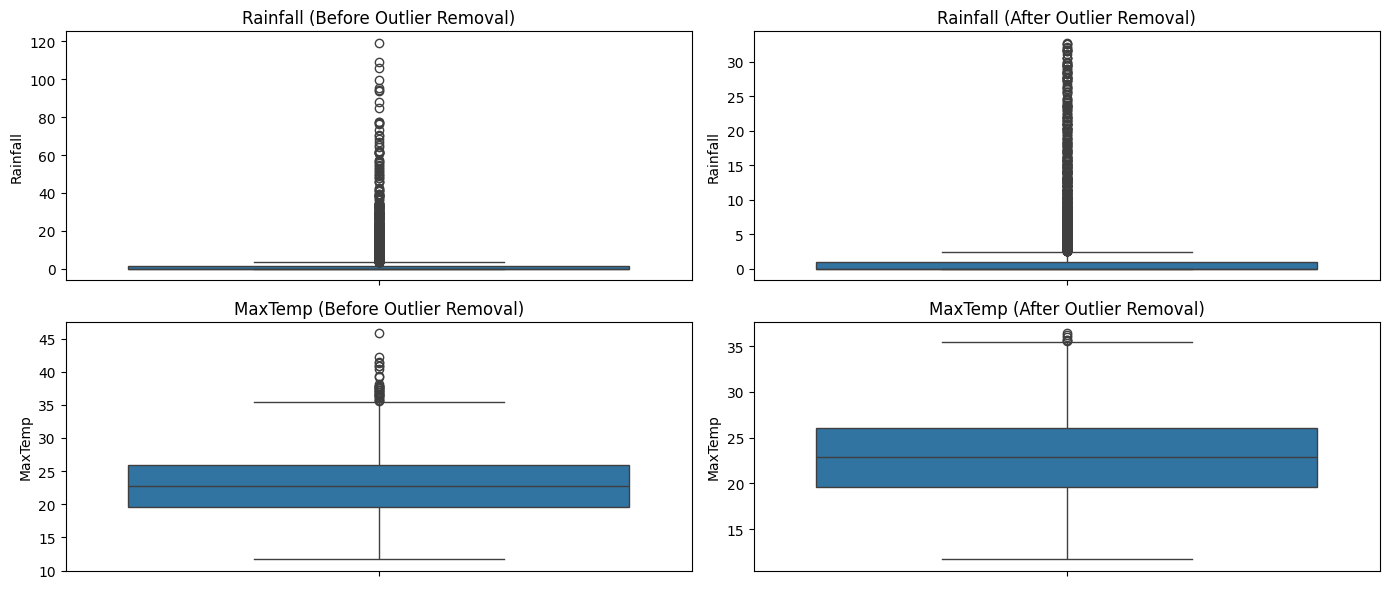

In [26]:
# Set up visual comparison
plt.figure(figsize=(14, 6))

# Rainfall
plt.subplot(2, 2, 1)
sns.boxplot(y=df_selected["Rainfall"])
plt.title("Rainfall (Before Outlier Removal)")

plt.subplot(2, 2, 2)
sns.boxplot(y=df_clean["Rainfall"])
plt.title("Rainfall (After Outlier Removal)")

# MaxTemp
plt.subplot(2, 2, 3)
sns.boxplot(y=df_selected["MaxTemp"])
plt.title("MaxTemp (Before Outlier Removal)")

plt.subplot(2, 2, 4)
sns.boxplot(y=df_clean["MaxTemp"])
plt.title("MaxTemp (After Outlier Removal)")

plt.tight_layout()
plt.show()


In [27]:
# Compute correlations
correlation_matrix = df_clean.corr(numeric_only=True)
correlation_with_rainfall = correlation_matrix["Rainfall"].sort_values(ascending=False)

# Display top correlations
print("Correlation with Rainfall:")
print(correlation_with_rainfall)


Correlation with Rainfall:
Rainfall        1.000000
Humidity3pm     0.283576
Cloud3pm        0.186503
MinTemp         0.040682
Pressure3pm     0.021585
WindSpeed3pm   -0.000783
MaxTemp        -0.110901
Name: Rainfall, dtype: float64


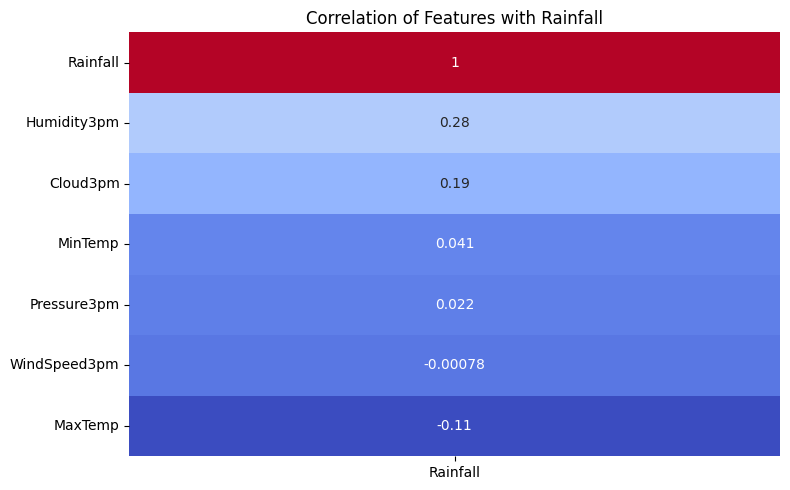

In [28]:
# Heatmap of correlations
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_with_rainfall.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation of Features with Rainfall")
plt.tight_layout()
plt.show()


In [29]:
# Select top 5 features (excluding Rainfall itself)
top_features = correlation_with_rainfall.drop("Rainfall").abs().sort_values(ascending=False).head(5)
print("Top 5 features for Rainfall prediction:")
print(top_features)


Top 5 features for Rainfall prediction:
Humidity3pm    0.283576
Cloud3pm       0.186503
MaxTemp        0.110901
MinTemp        0.040682
Pressure3pm    0.021585
Name: Rainfall, dtype: float64


In [30]:
# Set random seed for reproducibility
random_seed = 42

# Shuffle the dataset
df_shuffled = df_clean.sample(frac=1, random_state=random_seed).reset_index(drop=True)

# Split index
split_index = int(0.8 * len(df_shuffled))

# Create train and test sets
df_train = df_shuffled[:split_index].copy()
df_test = df_shuffled[split_index:].copy()

# Confirm sizes
print(f"Training set size: {df_train.shape[0]}")
print(f"Test set size: {df_test.shape[0]}")


Training set size: 2590
Test set size: 648
